In [11]:
# 1) Imports & Config
import os, json, random, warnings, itertools, pathlib, re
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa
import librosa.display
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Paden (pas aan t.o.v. je notebook locatie)
DATA_ROOT = "../data"
OUT_DIR   = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# Audio & STFT
TARGET_SR   = 16000
N_FFT       = 1024
HOP_LENGTH  = 256
WIN         = "hann"

# Filteroptie (bijv. nuttig voor 'new_microphone')
USE_BANDPASS_FOR_NEW = True
BP_LO_HZ, BP_HI_HZ, BP_ORDER = 120, 1800, 8

# Segmentatie
SEG_DUR = 3.0
STEP    = 0.0

# CNN beeldhoogte (Mel-bands)
IMG_HEIGHT = 128

# audio/feature
FMIN: int = 20
FMAX: Optional[int] = None             # None => sr/2
TOP_DB: float = 80.0                   # voor visualisatie/normalisatie

# afgeleide dims (géén center, zodat shapes deterministisch zijn)
FRAME_LEN_SAMPLES = int(round(SEG_DUR * TARGET_SR))
F_BINS = 1 + N_FFT // 2
T_BINS = 1 + max(0, (FRAME_LEN_SAMPLES - N_FFT)) // HOP_LENGTH

# Optionele handmatige override van labels per bestand
LABELS_OVERRIDE_JSON = os.path.join(OUT_DIR, "labels_override.json")
if not os.path.isfile(LABELS_OVERRIDE_JSON):
    with open(LABELS_OVERRIDE_JSON, "w") as f:
        json.dump({}, f, indent=2)  # {"relative/path.wav": "hoest" | "normaal" | "hart"}
with open(LABELS_OVERRIDE_JSON, "r") as f:
    LABELS_OVERRIDE = json.load(f)

In [12]:
# 2) Dataset indexeren en label-afleiding

@dataclass
class AudioItem:
    relpath: str
    abspath: str
    label: str       # 'hoest' | 'normaal' | 'hart' | 'onbekend'
    mic: str         # 'nieuw' | 'oud' | 'onbekend'
    source: str      # 'coughing' | 'heartsounds'

def infer_label_from_filename(fname: str) -> Optional[str]:
    """Heuristiek voor files in coughing/; heartsounds/ => 'hart' elders."""
    f = fname.lower()
    # hoest indicaties
    if any(k in f for k in ["cough", "hoest"]):
        return "hoest"
    # normaal adem indicaties
    if any(k in f for k in ["normal", "normaal", "breath", "adem"]):
        return "normaal"
    return None  # niet eenduidig

def infer_mic_from_path(path: str) -> str:
    p = path.replace("\\", "/").lower()
    if "/new_microphone/" in p:
        return "nieuw"
    if "/old_microphone/" in p:
        return "oud"
    return "onbekend"

def list_dataset(root: str) -> List[AudioItem]:
    items: List[AudioItem] = []
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            if not fn.lower().endswith(".wav"):
                continue
            abspath = os.path.join(dirpath, fn)
            relpath = os.path.relpath(abspath, root).replace("\\", "/")
            pnorm   = relpath.lower()
            mic     = infer_mic_from_path(relpath)

            if pnorm.startswith("heartsounds/"):
                label = "hart"
                source = "heartsounds"
            elif pnorm.startswith("coughing/"):
                source = "coughing"
                # override gaat vóór heuristiek
                label = LABELS_OVERRIDE.get(relpath, None)
                if label is None:
                    label = infer_label_from_filename(fn) or "onbekend"
            else:
                source = "onbekend"
                label = "onbekend"

            items.append(AudioItem(relpath=relpath, abspath=abspath, label=label, mic=mic, source=source))
    return items

items = list_dataset(DATA_ROOT)
df_files = pd.DataFrame([vars(x) for x in items])
# print("Totaal .wav:", len(df_files))
# display(df_files.head())

# Toon onduidelijk gelabelde files voor snelle correctie in labels_override.json
# df_unknown = df_files[(df_files["source"]=="coughing") & (df_files["label"]=="onbekend")]
# print("Niet eenduidig gelabeld in coughing/:", len(df_unknown))
# display(df_unknown[["relpath","mic"]].head(20))

# Exploratory Data Analysis (EDA) Rapport – Lung & Heart Sounds

In dit rapport analyseren we de opnames van hoesten, normale ademhaling en hartgeluiden, gemaakt met zowel de oude als de nieuwe microfoon.  
We gebruiken de segment-annotaties uit de `.json`-sidecars en voeren zowel signaalanalyse als feature-extractie uit.

---

## 1. Data-overzicht

In [13]:
# Data inladen en overzicht genereren
display(df_files.head())
print("Totaal aantal opnames:", len(df_files))
print("Verdeling labels (via JSON):")
display(df_files["label"].value_counts())

,relpath,abspath,label,mic,source
0,coughing/new_microphone/cough_1.wav,../data\coughing\new_microphone\cough_1.wav,hoest,nieuw,coughing
1,coughing/new_microphone/cough_2.wav,../data\coughing\new_microphone\cough_2.wav,hoest,nieuw,coughing
2,coughing/new_microphone/cough_3.wav,../data\coughing\new_microphone\cough_3.wav,hoest,nieuw,coughing
3,coughing/new_microphone/cough_4.wav,../data\coughing\new_microphone\cough_4.wav,hoest,nieuw,coughing
4,coughing/new_microphone/cough_5.wav,../data\coughing\new_microphone\cough_5.wav,hoest,nieuw,coughing


Totaal aantal opnames: 244
Verdeling labels (via JSON):


label
onbekend    204
hart         20
normaal      10
hoest        10
Name: count, dtype: int64

In [14]:
from IPython.display import Audio

# 4) EDA Quicklooks

def plot_quicklook(abspath: str, label: str, mic: str, sec: float = 5.0):
    y, sr = load_audio_mono(abspath)
    y_f   = maybe_filter(y, sr, mic)

    n = int(min(len(y_f), sec*sr))
    yv = y_f[:n]

    fig, axes = plt.subplots(1, 3, figsize=(16, 3))
    t = np.arange(len(yv))/sr
    axes[0].plot(t, yv)
    axes[0].set_title(f"Waveform ({label}, {mic})")
    axes[0].set_xlabel("s"); axes[0].set_ylabel("amp")

    S_db = stft_db(yv, sr)
    img1 = librosa.display.specshow(S_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set_title("STFT (dB)"); fig.colorbar(img1, ax=axes[1], format="%.0f dB")

    M_db = mel_db(yv, sr)
    img2 = librosa.display.specshow(M_db, sr=sr, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', ax=axes[2])
    axes[2].set_title("Mel (dB)"); fig.colorbar(img2, ax=axes[2], format="%.0f dB")
    plt.tight_layout(); plt.show()

    # Playback audio fragment
    display(Audio(yv, rate=sr))

## 2. Voorbeelden van waveforms en spectrogrammen

We bekijken per klasse (Hoest, Normaal, Hart) een voorbeeld van de golfvorm, STFT-spectrogram en Mel-spectrogram.

In [ ]:
for lbl in ["hoest","normaal","hart"]:
    row = df_files[df_files["label"]==lbl].head(1)
    if len(row):
        plot_quicklook(row["abspath"].iloc[0], lbl, row["mic"].iloc[0], sec=5.0)

NameError: name 'load_audio_mono' is not defined

## Voorbeelden van oude- en nieuwe stethoscoop

Om het verschil te zien in de nieuwe en oude stethoscoop die gebruikt wordt in de pi-opstelling tonen we hier een voorbeeld golfvorm, STFT-spectrogram en Mel-spectrogram.

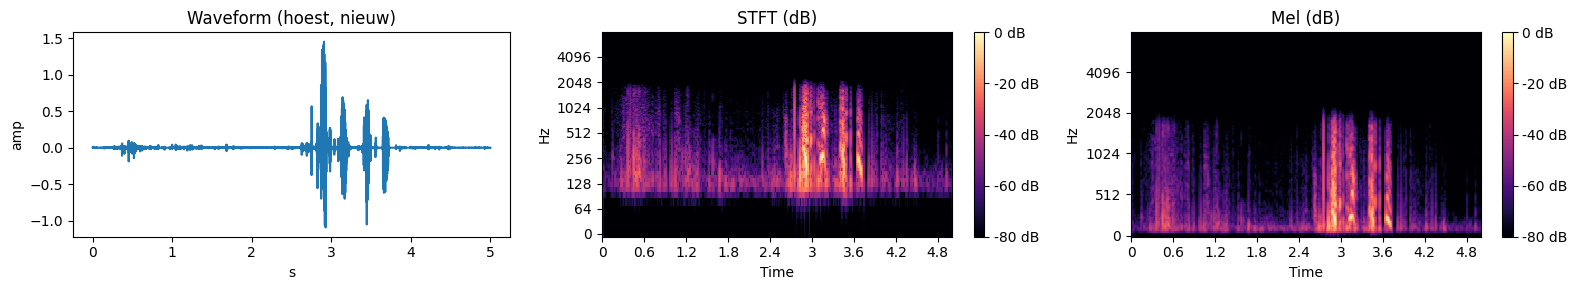

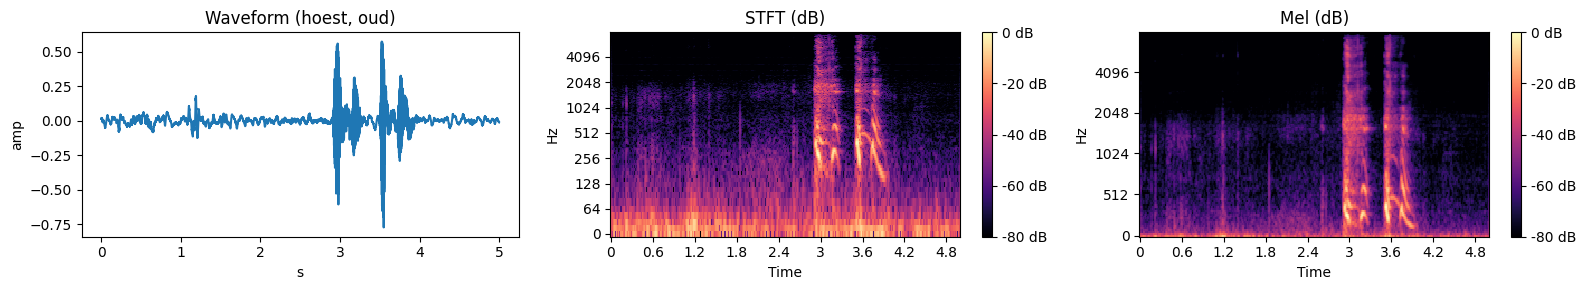

In [ ]:
# Plot 1 "hoest" voorbeeld met oude microfoon en 1 met nieuwe microfoon
row_nieuw = df_files[(df_files["label"] == "hoest") & (df_files["mic"] == "nieuw")].head(1)
row_oud   = df_files[(df_files["label"] == "hoest") & (df_files["mic"] == "oud")].head(1)

for _, r in pd.concat([row_nieuw, row_oud]).iterrows():
    plot_quicklook(r["abspath"], r["label"], r["mic"], sec=5.0)

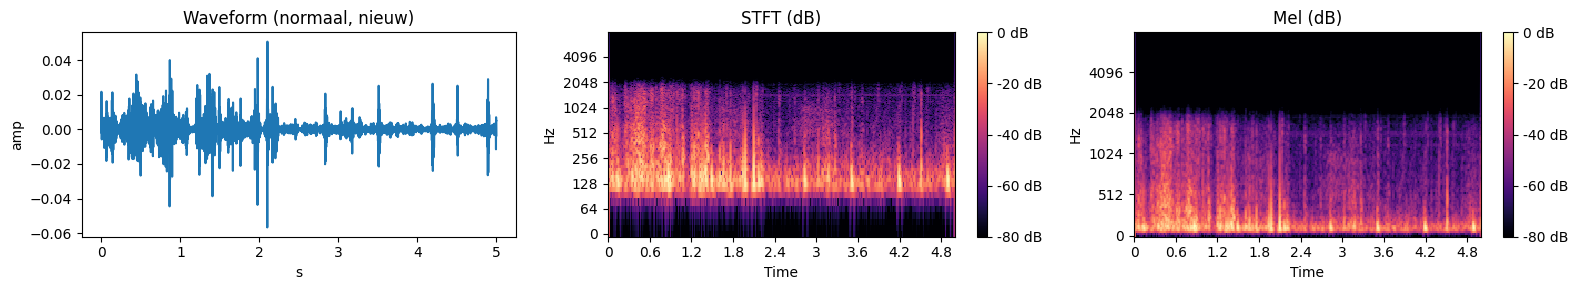

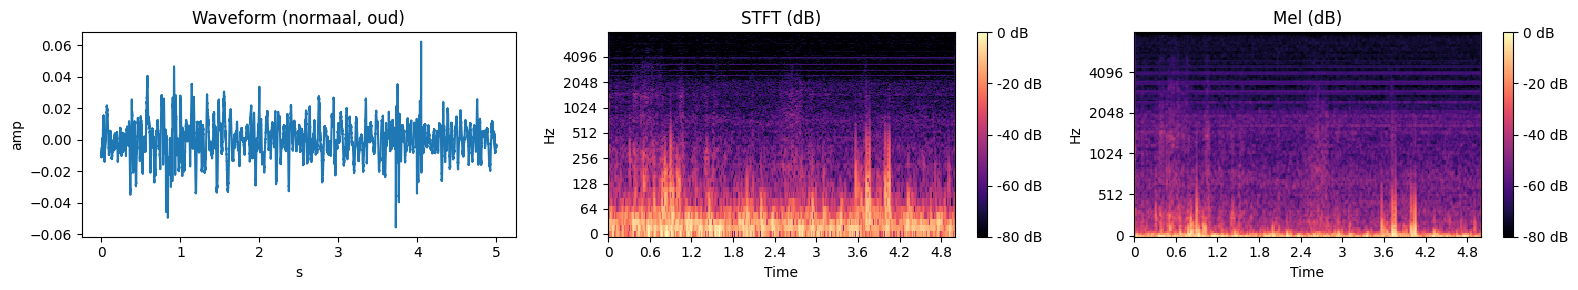

In [ ]:
# Plot 1 "normaal" voorbeeld met oude microfoon en 1 met nieuwe microfoon
row_nieuw = df_files[(df_files["label"] == "normaal") & (df_files["mic"] == "nieuw")].head(1)
row_oud   = df_files[(df_files["label"] == "normaal") & (df_files["mic"] == "oud")].head(1)

for _, r in pd.concat([row_nieuw, row_oud]).iterrows():
    plot_quicklook(r["abspath"], r["label"], r["mic"], sec=5.0)

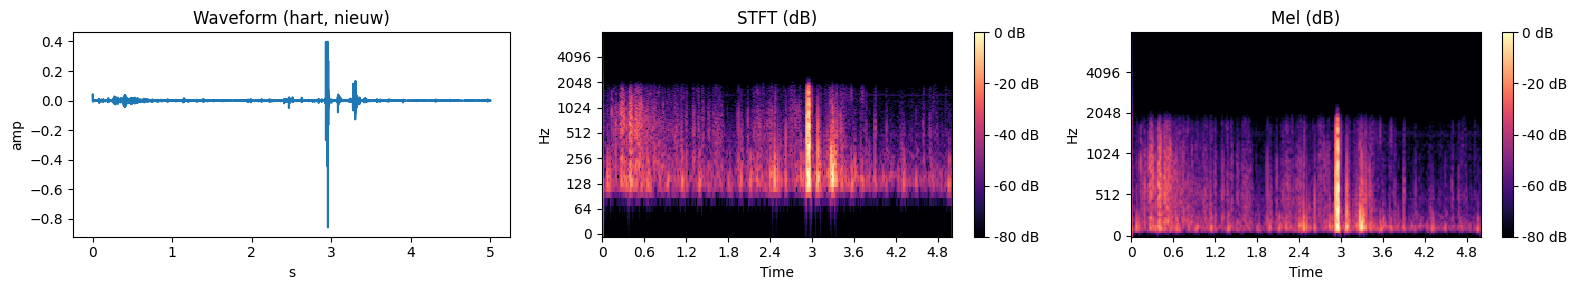

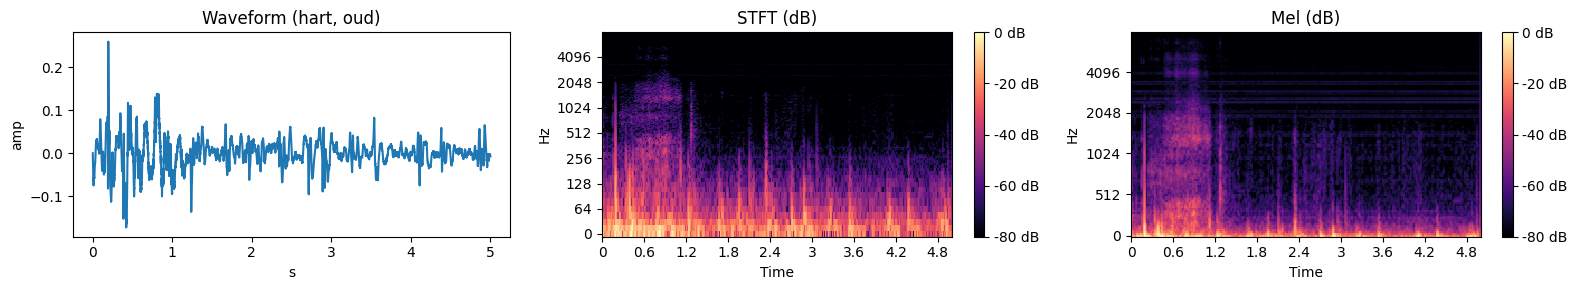

In [ ]:
# Plot 1 "hart" voorbeeld met oude microfoon en 1 met nieuwe microfoon
row_nieuw = df_files[(df_files["label"] == "hart") & (df_files["mic"] == "nieuw")].head(1)
row_oud   = df_files[(df_files["label"] == "hart") & (df_files["mic"] == "oud")].head(1)

for _, r in pd.concat([row_nieuw, row_oud]).iterrows():
    plot_quicklook(r["abspath"], r["label"], r["mic"], sec=5.0)

In [ ]:
# Cel D — Interactieve visualisatie + audio-terugluisteren
# STFT parameters
n_fft = 1024
hop_length = 256
win = "hann"

# UI controls
idx_slider   = widgets.IntSlider(value=0, min=0, max=len(df)-1, step=1, description='Index:')
use_filter   = widgets.Checkbox(value=False, description='Bandpass aan')
low_box      = widgets.FloatText(value=50.0, description='Low (Hz):', step=1.0)
high_box     = widgets.FloatText(value=2000.0, description='High (Hz):', step=1.0)
order_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Order:')
zero_chk     = widgets.Checkbox(value=True, description='Zero-phase')

ui_left  = widgets.VBox([idx_slider, use_filter, low_box, high_box, order_slider, zero_chk])
out_area = widgets.Output()

def _update(idx, use_filter, low, high, order, zero_phase):
    with out_area:
        out_area.clear_output(wait=True)

        # Bestand kiezen + labels ophalen
        row = df.iloc[idx]
        wav_file = row["path"]
        task_lbl = row.get("label_task", "unknown")
        mic_lbl  = row.get("label_mic", "unknown")
        title_suffix = f"[{task_lbl} | {mic_lbl}]"

        # Audio laden (cached)
        y, sr = load_audio_cached(wav_file)

        # Optioneel filteren voor afspelen + plotten
        y_view = y
        if use_filter:
            high_eff = min(float(high), sr/2 - 1.0)
            y_view = bandpass_filter(y_view, fs=sr, fc=(float(low), high_eff),
                                     order=int(order), zero_phase=bool(zero_phase))
            fmax_plot = high_eff
        else:
            fmax_plot = sr / 2.0

        # Waveform
        plt.figure(figsize=(12, 3))
        librosa.display.waveshow(y_view, sr=sr)
        plt.title(f"Waveform — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Tijd (s)")
        plt.ylabel("Amplitude")
        plt.tight_layout()
        plt.show()

        # STFT
        S = librosa.stft(y_view, n_fft=n_fft, hop_length=hop_length,
                         win_length=n_fft, window=win, center=True)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr,
                                       hop_length=hop_length, n_fft=n_fft)
        freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

        mask = freqs <= fmax_plot
        if not np.any(mask):
            mask = freqs <= (sr/2.0)
        freqs_plot = freqs[mask]
        S_db_plot  = S_db[mask, :]

        plt.figure(figsize=(12, 4))
        plt.pcolormesh(times, freqs_plot, S_db_plot, shading="auto")
        plt.title(f"STFT — {Path(wav_file).name} {title_suffix}")
        plt.xlabel("Tijd (s)")
        plt.ylabel("Frequentie (Hz)")
        cbar = plt.colorbar()
        cbar.set_label("Amplitude (dB)")
        plt.ylim(0.0, fmax_plot)
        plt.tight_layout()
        plt.show()

        # Audio player (volledige clip)
        display(Audio(y_view, rate=sr))

# Koppel controls aan output zonder de UI telkens te hercreëren (stabieler dan interact())
controls = {
    'idx': idx_slider,
    'use_filter': use_filter,
    'low': low_box,
    'high': high_box,
    'order': order_slider,
    'zero_phase': zero_chk,
}
linked_out = widgets.interactive_output(_update, controls)

display(widgets.HBox([ui_left, out_area]))
# Initiele render
_update(idx_slider.value, use_filter.value, low_box.value, high_box.value, order_slider.value, zero_chk.value)

In [ ]:
# 3) Audio helpers

def load_audio_mono(path: str, target_sr: int = TARGET_SR) -> Tuple[np.ndarray, int]:
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y.astype(np.float32), sr

def butter_bandpass_apply(y: np.ndarray, sr: int, lo_hz: float, hi_hz: float, order: int = 8) -> np.ndarray:
    sos = signal.butter(order, [lo_hz, hi_hz], btype='bandpass', fs=sr, output='sos')
    return signal.sosfiltfilt(sos, y).astype(np.float32)

def maybe_filter(y: np.ndarray, sr: int, mic: str) -> np.ndarray:
    if USE_BANDPASS_FOR_NEW and mic == "nieuw":
        return butter_bandpass_apply(y, sr, BP_LO_HZ, BP_HI_HZ, BP_ORDER)
    return y

def stft_db(y: np.ndarray, sr: int) -> np.ndarray:
    S = librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH, window=WIN)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    return S_db

def mel_db(y: np.ndarray, sr: int, n_mels=IMG_HEIGHT) -> np.ndarray:
    M = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH,
                                       n_mels=n_mels, fmin=20, fmax=sr//2)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

## 4. Feature-extractie (MFCC + spectrale features)

Voor elk segment worden klassieke audiofeatures berekend:
- **MFCCs** (Mel-Frequency Cepstral Coefficients)
- **Zero Crossing Rate**
- **Spectral Centroid**
- **Spectral Bandwidth**
- **Spectral Rolloff**

Hiermee kunnen we patronen tussen de klassen verkennen.


In [ ]:
# 6) Feature-extractie op basis van t_start/t_end (JSON)

def extract_features_from_segment(y: np.ndarray, sr: int) -> Dict[str, float]:
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()
    sc  = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
    sbw = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0].mean()
    roll= librosa.feature.spectral_rolloff(y=y, sr=sr, roll_percent=0.95)[0].mean()
    feat = {f"mfcc_{i+1}": float(mfcc_mean[i]) for i in range(len(mfcc_mean))}
    feat.update({"zcr": float(zcr), "centroid": float(sc), "bandwidth": float(sbw), "rolloff": float(roll)})
    return feat

def slice_by_time(y: np.ndarray, sr: int, t0: float, t1: float) -> np.ndarray:
    a = max(0, int(round(t0 * sr)))
    b = min(len(y), int(round(t1 * sr)))
    if b <= a:
        return np.zeros(int((t1 - t0) * sr), dtype=np.float32) if t1 > t0 else np.zeros(0, dtype=np.float32)
    return y[a:b]

def featurize_from_json_segments(df_segs: pd.DataFrame) -> pd.DataFrame:
    rows = []
    # Cache audios om IO te beperken
    cache: dict[str, tuple[np.ndarray,int,str]] = {}  # abspath -> (y_filtered, sr, mic)
    for _, r in df_segs.iterrows():
        abspath = r["abspath"]
        mic     = r["mic"]
        if abspath not in cache:
            y, sr = load_audio_mono(abspath, target_sr=TARGET_SR)
            y = maybe_filter(y, sr, mic)
            cache[abspath] = (y, sr, mic)
        y, sr, mic = cache[abspath]
        seg = slice_by_time(y, sr, float(r["t_start"]), float(r["t_end"]))
        if seg.size == 0:
            continue
        f = extract_features_from_segment(seg, sr)
        f.update(dict(label=r["label"], mic=mic, relpath=r["relpath"], seg_id=r["seg_id"],
                      t_start=float(r["t_start"]), t_end=float(r["t_end"])))
        rows.append(f)
    return pd.DataFrame(rows)

df_feat = featurize_from_json_segments(df_segs)

In [ ]:
print("Features shape:", df_feat.shape)
display(df_feat.head())
print("Gemiddelde feature-waarden per klasse:")
numeric_cols = df_feat.select_dtypes(include=[np.number]).columns
display(df_feat.groupby("label")[numeric_cols].mean().round(3))

Features shape: (369, 23)


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,...,zcr,centroid,bandwidth,rolloff,label,mic,relpath,seg_id,t_start,t_end
0,-404.921875,122.420212,27.413782,-10.158631,2.331894,4.567115,-9.318842,-11.808268,-6.464476,-10.030030,...,0.025095,420.019047,376.521653,1241.273271,hoest,nieuw,coughing/new_microphone/cough_1.wav,dae77b6c-e8e4-43cc-baaf-b56cf1bd01ef,1.68,4.68
1,-456.585114,149.847641,22.316982,-23.791681,1.346690,9.333824,-11.762724,-17.932196,-7.921372,-9.270938,...,0.028061,454.275606,401.086138,1318.068484,hoest,nieuw,coughing/new_microphone/cough_1.wav,de8a067b-e2d6-4660-8589-189294866f25,6.80,9.80
2,-446.479218,144.458145,25.232069,-21.417549,-2.114806,5.198286,-11.392952,-15.374102,-6.761788,-8.559907,...,0.029951,453.986253,392.207097,1314.245346,hoest,nieuw,coughing/new_microphone/cough_1.wav,9d213259-75ac-428e-83e2-10dbe74a88e3,11.93,14.93
3,-441.228638,138.247559,26.441666,-15.736995,2.640833,6.628417,-11.928664,-15.840724,-6.789905,-8.758822,...,0.031702,433.174274,363.986660,1220.661569,hoest,nieuw,coughing/new_microphone/cough_1.wav,c2b67ec8-0263-4b8a-be39-088835a9678f,16.77,19.77
4,-445.275513,127.316666,27.559715,-12.352078,2.046328,5.699531,-10.617659,-14.851522,-6.937764,-7.953154,...,0.026227,437.344485,391.731170,1297.207447,hoest,nieuw,coughing/new_microphone/cough_1.wav,e712c1eb-c012-4b39-bf22-b9c94126352d,21.38,24.38


Gemiddelde feature-waarden per klasse:


,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,zcr,centroid,bandwidth,rolloff,t_start,t_end
label,,,,,,,,,,,,,,,,,,,
hart,-655.454,143.459,32.562,5.443,19.765,20.811,4.051,0.009,9.180,4.014,-5.218,-2.770,-0.033,0.016,313.781,575.874,1003.693,13.500,16.500
hoest,-418.022,119.268,28.600,5.573,15.820,12.953,-3.409,-2.805,3.028,-0.386,-5.697,-4.953,-4.244,0.020,402.302,601.594,1468.650,14.185,17.156
normaal,-633.845,143.999,24.209,7.988,19.955,20.579,0.787,-0.948,10.634,5.045,-4.783,-1.676,-0.642,0.013,353.530,715.268,1647.854,13.664,16.647


## 5. Basis-statistieken per segment

Naast de uitgebreide feature-set bekijken we eenvoudige statistieken:
- RMS (energie)
- Zero Crossing Rate
- Spectral Centroid


In [ ]:
# 5) Basis-statistieken per segment

def basic_stats_segment(y: np.ndarray, sr: int) -> dict:
    rms = np.sqrt(np.mean(y**2))
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()
    sc  = librosa.feature.spectral_centroid(y=y, sr=sr)[0].mean()
    return {"rms": rms, "zcr": zcr, "centroid": sc}

def compute_basic_stats(df_segs: pd.DataFrame) -> pd.DataFrame:
    rows = []
    cache = {}
    for _, r in df_segs.iterrows():
        abspath = r["abspath"]
        if abspath not in cache:
            y, sr = load_audio_mono(abspath, target_sr=TARGET_SR)
            y = maybe_filter(y, sr, r["mic"])
            cache[abspath] = (y, sr)
        y, sr = cache[abspath]
        seg = slice_by_time(y, sr, r["t_start"], r["t_end"])
        if seg.size == 0:
            continue
        f = basic_stats_segment(seg, sr)
        f.update(dict(label=r["label"], mic=r["mic"], seg_id=r["seg_id"]))
        rows.append(f)
    return pd.DataFrame(rows)

df_stats = compute_basic_stats(df_segs)

In [ ]:
display(df_stats.groupby("label")[["rms","zcr","centroid"]].mean().round(4))

,rms,zcr,centroid
label,,,
hart,0.0156,0.0164,313.7809
hoest,0.0885,0.0202,402.3017
normaal,0.0089,0.0132,353.5305


## 6. Vergelijking amplitude en spectrale energie

We vergelijken de gemiddelde energie in frequentiebanden:
- 0–150 Hz (harttonen)
- 150–600 Hz (ademhaling)
- 600–2000 Hz (hoest, breedband energie)

,energy_0-150Hz,energy_150-600Hz,energy_600-2000Hz
label,,,
hart,124.949997,0.570000,0.120000
hoest,428.029999,1070.109985,271.790009
normaal,31.030001,0.460000,0.030000


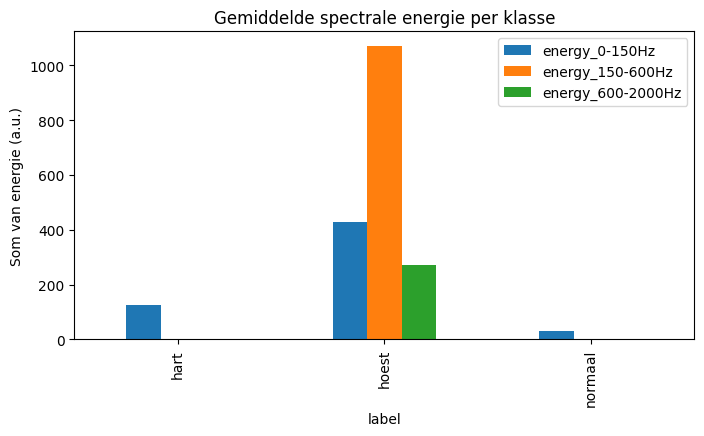

In [ ]:
# Select only numeric energy columns before groupby mean
energy_cols = [c for c in df_energy.columns if c.startswith("energy_")]
energy_means = df_energy.groupby("label")[energy_cols].mean()
display(energy_means.round(2))
energy_means.plot(kind="bar", figsize=(8,4))
plt.title("Gemiddelde spectrale energie per klasse")
plt.ylabel("Som van energie (a.u.)")
plt.show()

## 7. Hoogtepunten in frequentiedomein

We kwantificeren waar de belangrijkste frequentiecomponenten liggen:
- Dominante frequentie
- Verhouding energie onder vs. boven 150 Hz

In [ ]:
display(df_freq.groupby("label")[["max_freq","energy_below150","energy_above150"]].mean().round(2))

,max_freq,energy_below150,energy_above150
label,,,
hart,73.20,11.990000,2.070000
hoest,95.49,21.860001,68.510002
normaal,69.29,6.950000,2.300000


## 8. Visualisaties van patronen

Met scatterplots en boxplots verkennen we visuele patronen tussen de klassen.

In [ ]:
# Visualisatie van patronen

import seaborn as sns

# RMS vs. spectral centroid
sns.scatterplot(data=df_stats, x="centroid", y="rms", hue="label")
plt.title("RMS vs Spectral Centroid per segment")
plt.show()

# Zero Crossing Rate per klasse (boxplot)
sns.boxplot(data=df_stats, x="label", y="zcr")
plt.title("Zero Crossing Rate per klasse")
plt.show()

# Max freq per klasse (boxplot)
sns.boxplot(data=df_freq, x="label", y="max_freq")
plt.title("Max frequentiecomponent per klasse")
plt.show()

## 9. Klassieke ML-baselines

We evalueren eenvoudige modellen (SVM, RandomForest) op drie binaire taken:
- Hoest vs. Normaal
- Hoest vs. Hart
- Normaal vs. Hart

In [ ]:
# Hulpfunctie: pak uitsluitend numerieke feature-kolommen en vul NaNs
def get_numeric_features(df: pd.DataFrame,
                         drop_cols=("label","mic","relpath","seg_id","t_start","t_end")) -> pd.DataFrame:
    dfX = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    dfX = dfX.select_dtypes(include=[np.number]).copy()
    # Eventueel lege kolommen weg, en NaNs vullen
    dfX = dfX.loc[:, dfX.columns.notnull()]
    dfX = dfX.fillna(0.0)
    # Als er per ongeluk niets overblijft, geef een duidelijke fout
    if dfX.shape[1] == 0:
        raise ValueError("Geen numerieke features gevonden; controleer je feature-pipeline.")
    return dfX

In [ ]:
# 7. Baselines met klassieke ML (gefixte versie)
def run_pairwise_baseline(df_feat: pd.DataFrame, a: str, b: str, model="svm"):
    df_ab = df_feat[df_feat["label"].isin([a,b])].copy()
    # Sanity: genoeg samples per klasse?
    counts = df_ab["label"].value_counts()
    if not set([a,b]).issubset(counts.index):
        print(f"Skipping {a} vs {b}: niet beide klassen aanwezig ({counts.to_dict()}).")
        return
    if (counts[a] < 2) or (counts[b] < 2):
        print(f"Skipping {a} vs {b}: te weinig voorbeelden per klasse voor stratify ({counts.to_dict()}).")
        return

    X = get_numeric_features(df_ab)        # <— alleen numeriek
    y = df_ab["label"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=min(0.25, max(0.25, 1.0/len(y))), random_state=SEED, stratify=y
    )

    if model == "svm":
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(kernel="rbf", probability=False, random_state=SEED))
        ])
    else:
        clf = RandomForestClassifier(n_estimators=300, random_state=SEED)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"=== {a} vs {b} — {model.upper()} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print(confusion_matrix(y_test, y_pred))

In [ ]:
for mdl in ["svm","rf"]:
    run_pairwise_baseline(df_feat, "hoest",   "normaal", model=mdl)
    run_pairwise_baseline(df_feat, "hoest",   "hart",    model=mdl)
    run_pairwise_baseline(df_feat, "normaal", "hart",    model=mdl)


=== hoest vs normaal — SVM ===
              precision    recall  f1-score   support

       hoest      1.000     1.000     1.000        14
     normaal      1.000     1.000     1.000        29

    accuracy                          1.000        43
   macro avg      1.000     1.000     1.000        43
weighted avg      1.000     1.000     1.000        43

[[14  0]
 [ 0 29]]
=== hoest vs hart — SVM ===
              precision    recall  f1-score   support

        hart      1.000     1.000     1.000        50
       hoest      1.000     1.000     1.000        14

    accuracy                          1.000        64
   macro avg      1.000     1.000     1.000        64
weighted avg      1.000     1.000     1.000        64

[[50  0]
 [ 0 14]]
=== normaal vs hart — SVM ===
              precision    recall  f1-score   support

        hart      0.980     1.000     0.990        50
     normaal      1.000     0.966     0.982        29

    accuracy                          0.987        79
 